# Linear Regression with Correlated Errors in X and Y

Here we simulate a dataset where the dependent variable y is measured as (linear) function of the independent variable x. In order to simulate correlated errors between x and y, Each x has a "true" value and a measured value which is again subject to measurement uncertainty. The resulting value of y (which by itself has no measurement uncertainty) is calculated according to the "true" value of x, which is not the same as the value of x that you measure.

For example: You measure the electrical current through a resistor as function of the applied voltage. You set the voltage to a certain value on your voltage source. That is value that you assume it to be. However, the true voltage applied is subject to noise which will affect the measured current.  

We measure m data points (meaning m different values of x). For each of these data points we measure x and y n times. Due to the measurement (quantified as "noisemeasurementuncertainty") we will measure different values of x every time. But there is also an underlying random distribution of the values of x because our instrument  that sources x is subject to output noise (quantified as "outputnoise" in the code). 
We calculate the mean values of x and y and their variances as well as their correlation coefficient r to obtain m data points with their uncertainties. 

You can change the parameters of 

measurementuncertainty  - the uncertainty of your measurement of x.
outputnoise - the uncertainty of how precise you can set x.

m - number of points.
n - number of measurements per point.

x_min x_max - the measurement range.


## Load Libraries

In [1]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Data

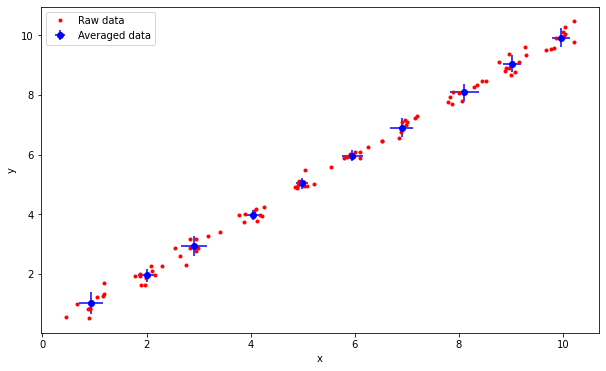

In [2]:
# Correlated errors

# linear model
def model(x,a,b):
    return a+b*x

# Number of data points
m = 10
x_min = 1
x_max = 10
dx = (x_max - x_min)/m

x_set = np.linspace(x_min, x_max, m)

# Model parameter
a = 0
b = 1

# Random uncertainty of the measurement of the dependent variable
measurementuncertainty = 0.2
outputnoise = 0.2

# Raw data of independent variable
# points per point
n = 10

x_binned = np.zeros((m,n))
y_binned = np.zeros((m,n))

# Initilaization
x = np.zeros(m)
y = np.zeros(m)

xerr = np.zeros(m)
yerr = np.zeros(m)

r = np.zeros(m)

for i in range(0,m):
    xx = np.random.normal(x_set[i], outputnoise, n) 
    s_y = np.random.normal(0, measurementuncertainty, n)
    yy = model(xx,a,b)+s_y
    
    x_binned[i,:] = xx
    y_binned[i,:] = yy
    x[i] = np.mean(xx)
    y[i] = np.mean(yy)
    cov = np.cov(xx,yy)
    xerr[i] = np.sqrt(cov[0,0])
    yerr[i] = np.sqrt(cov[1,1])
    r[i] = cov[1,0]/np.sqrt(cov[0,0]*cov[1,1])
    
    
x_raw = np.reshape(x_binned, n*m)
y_raw = np.reshape(y_binned, n*m)

wx = 1/xerr**2
wy = 1/yerr**2

# Plot data
plt.figure(
    num=1,
    figsize=(10,6),
    facecolor='white')
plt.xlabel('x')
plt.ylabel('y')
plt.plot(x_raw,y_raw,'r.', label='Raw data')
plt.errorbar(x, y, yerr, xerr, fmt='bo', label='Averaged data')
plt.legend(loc=2)
plt.show()

## Simple linear regression without any weights

b = 1.00
a = 0.02


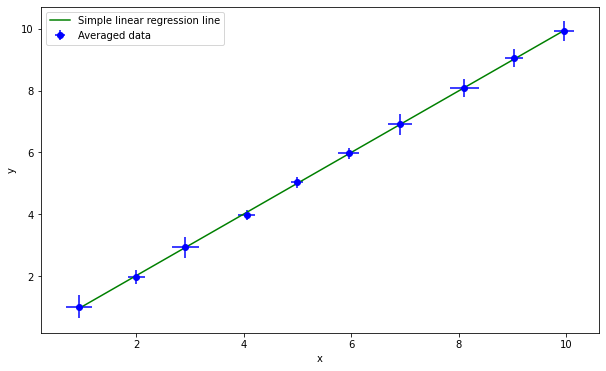

In [3]:
# Simple linear regression to obtain initial guess for b
cov = np.cov(x,y)

b_linreg = cov[0,1]/cov[0,0]
a_linreg = np.mean(y)-b_linreg*np.mean(x)

y_linreg = a_linreg+b_linreg*x

print("b = {:0.2f}".format(b_linreg))
print("a = {:0.2f}".format(a_linreg))

plt.figure(
    num=1,
    figsize=(10,6),
    facecolor='white')
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x, y, yerr, xerr, fmt='bo', label='Averaged data')
plt.plot(x,y_linreg,'g', label='Simple linear regression line')
plt.legend(loc=2)
plt.show()

## Linear regression with errors in x and y considering correlated errors

Number of iterations: 5
b = 0.998  +/- 0.023
a = 0.01  +/- 0.14


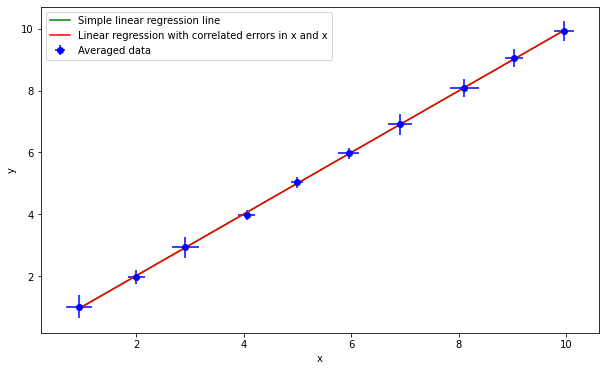

In [4]:
# Iterative fitting procedure

# maximal number of iterations
i_max = 100

# Initial value of b
cov = np.cov(x,y)
b = cov[0,1]/cov[0,0]

delta_b = 1
i = 0

while (delta_b>1e-10)and(i<i_max):
    b_old = b

    i = i+1
    
    alpha = np.sqrt(wx*wy)
    w = wx*wy/(wx+wy*b**2-2*b*r*alpha)
    x_bar = np.sum(w*x)/np.sum(w)
    y_bar = np.sum(w*y)/np.sum(w)
    u = x-x_bar
    v = y-y_bar
    beta = w*(u/wy+b*v/wx-(b*u+v)*r/alpha)
    b = np.sum(w*beta*v)/np.sum(w*beta*u)
    delta_b = np.abs(b-b_old)
    
a = y_bar-b*x_bar

x_adj = x_bar+beta
y_adj = y_bar+b*beta

x_bar_adj = np.sum(w*x_adj)/np.sum(w)
y_bar_adj = np.sum(w*y_adj)/np.sum(w)

u_adj = x_adj-x_bar_adj
v_adj = y_adj-y_bar_adj

var_b_adj = 1/np.sum(w*u_adj**2)
var_a_adj = 1/np.sum(w)+x_bar_adj**2*var_b_adj

var_b = 1/np.sum(w*u**2)
var_a = 1/np.sum(w)+x_bar**2*var_b

y_linreg_w = a+b*x

print("Number of iterations: {:1.0f}".format(i))
print("b = {:0.3f}".format(b)," +/- {:0.3f}".format(np.sqrt(var_b)))
print("a = {:0.2f}".format(a)," +/- {:0.2f}".format(np.sqrt(var_a)))

plt.figure(
    num=1,
    figsize=(10,6),
    facecolor='white')
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x, y, yerr, xerr, fmt='bo', label='Averaged data')
plt.plot(x,y_linreg,'g', label='Simple linear regression line')
plt.plot(x,y_linreg_w,'r', label='Linear regression with correlated errors in x and x')
plt.legend(loc=2)
plt.show()

## Linear regression with errors in x and y without considering correlated errors

Number of iterations: 4
b = 1.001  +/- 0.039
a = -0.01  +/- 0.22


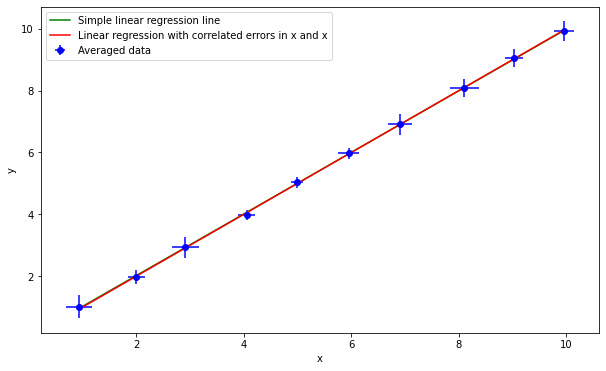

In [5]:
# Iterative fitting procedure

# maximal number of iterations
i_max = 100

# Initial value of b
cov = np.cov(x,y)
b = cov[0,1]/cov[0,0]

delta_b = 1
i = 0
r = 0

while (delta_b>1e-10)and(i<i_max):
    b_old = b

    i = i+1
    
    alpha = np.sqrt(wx*wy)
    w = wx*wy/(wx+wy*b**2-2*b*r*alpha)
    x_bar = np.sum(w*x)/np.sum(w)
    y_bar = np.sum(w*y)/np.sum(w)
    u = x-x_bar
    v = y-y_bar
    beta = w*(u/wy+b*v/wx-(b*u+v)*r/alpha)
    b = np.sum(w*beta*v)/np.sum(w*beta*u)
    delta_b = np.abs(b-b_old)
    
a = y_bar-b*x_bar

x_adj = x_bar+beta
y_adj = y_bar+b*beta

x_bar_adj = np.sum(w*x_adj)/np.sum(w)
y_bar_adj = np.sum(w*y_adj)/np.sum(w)

u_adj = x_adj-x_bar_adj
v_adj = y_adj-y_bar_adj

var_b_adj = 1/np.sum(w*u_adj**2)
var_a_adj = 1/np.sum(w)+x_bar_adj**2*var_b_adj

var_b = 1/np.sum(w*u**2)
var_a = 1/np.sum(w)+x_bar**2*var_b

y_linreg_w = a+b*x

print("Number of iterations: {:1.0f}".format(i))
print("b = {:0.3f}".format(b)," +/- {:0.3f}".format(np.sqrt(var_b)))
print("a = {:0.2f}".format(a)," +/- {:0.2f}".format(np.sqrt(var_a)))

plt.figure(
    num=1,
    figsize=(10,6),
    facecolor='white')
plt.xlabel('x')
plt.ylabel('y')
plt.errorbar(x, y, yerr, xerr, fmt='bo', label='Averaged data')
plt.plot(x,y_linreg,'g', label='Simple linear regression line')
plt.plot(x,y_linreg_w,'r', label='Linear regression with correlated errors in x and x')
plt.legend(loc=2)
plt.show()